In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [224]:
kc_house_df = pd.read_csv("data/kc_house_data.csv", index_col='id')

In [225]:
kc_house_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


This data has missing values and appears to have default/dummy ones as well.
Not particularly sure how useful Lat/Long will be given that it's all in one area. Probably not usable unless we group it into something resembling neighborhood data.

In [226]:
kc_house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

yr_renovated seems problematic, could be changed to a categorical column of a renovated yes or no. Also possible to look at columns of differences between yr_renovated and date or yr_built. 

In [227]:
date_range = pd.to_datetime(kc_house_df['date'])
print(date_range.max(), date_range.min())
date_range.loc[(date_range.dt.year != 2014) & (date_range.dt.year != 2015)]

2015-05-27 00:00:00 2014-05-02 00:00:00


Series([], Name: date, dtype: datetime64[ns])

We're dealing with a year of sale data, could do some month to month comparisons, or add in columns with categorized data. On intial inspection it appears there are no null or dummy values.

In [228]:
stripped_down_df = kc_house_df.loc[:, ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
# sns.pairplot(stripped_down_df) # Pairplot of the recommended columns from the project description. 

<AxesSubplot:>

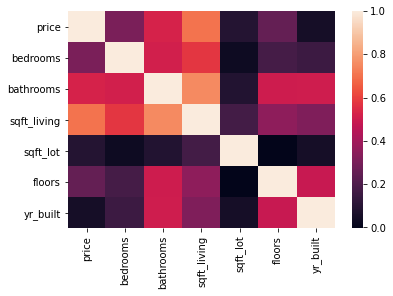

In [229]:
sns.heatmap(stripped_down_df.corr())

## Starting Regressions

A few exploratory models to see what we have to work with.

### Simple Regression

Just using the `sqft_living` column, as that's the one with the highest correlation with price.

In [230]:
# Get the specific columns out we want for the regression
X = stripped_down_df.loc[:, ['sqft_living']]
y = stripped_down_df.loc[:, ['price']]
plot_data = stripped_down_df.loc[:, ['price', 'sqft_living']]


beginner_reg = LinearRegression()
beginner_reg.fit(X, y)
prediction = beginner_reg.predict(X)

# Plot regression line over scatter plot
# fig, ax = plt.subplots()
# sns.scatterplot(data=plot_data, x='sqft_living', y='price', ax=ax, alpha=0.5);
# sns.lineplot(x=X['sqft_living'], y=prediction[:, 0], ax=ax, color='r');


In [231]:
print(f"R Squared Score: {beginner_reg.score(X, y)}")
print("RSME: ", mean_squared_error(y, beginner_reg.predict(X), squared=False))

R Squared Score: 0.49268789904035093
RSME:  261655.00451904474


In [232]:
stats_models_version = sm.OLS(y['price'], sm.add_constant(X)).fit()

In [233]:
stats_models_version.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:22:58   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [234]:
inter_df = stripped_down_df.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built', 'price']]
X_more = inter_df.drop('price', axis=1)
y_more = inter_df.price

inter_reg = LinearRegression()
inter_reg.fit(X_more, y_more)
print(f"R Squared Score: {inter_reg.score(X_more, y_more)}")
print(f"Coefficients: {inter_reg.coef_}")


R Squared Score: 0.5562851846502235
Coefficients: [ 3.03767349e+02  6.74690231e+04 -6.89999611e+04 -3.01545416e-01
  5.42136300e+04 -3.36761796e+03]


In [235]:
# sns.pairplot(inter_df)

In [236]:
stats_models_version_inter = sm.OLS(y_more, sm.add_constant(X_more)).fit()
stats_models_version_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4511.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:22:58   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21590   BIC:                         5.973e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.559e+06   1.35e+05     48.643      0.000     6.3e+06    6.82e+06
sqft_living   303.7673      3.000    101.249      0.000     297.887     309.648
bathrooms    6.747e+04   3851.524     17.517      0.000    5.99e+04     7.5e+04
bedrooms      -6.9e+04   2253.108    -30.624      0.000   -7.34e+04   -6.46e+04
sqft_lot       -0.3015      0.041     -7.329      0.000      -0.382      -0.221
floors       5.421e+04   3778.051     14.350      0.000    4.68e+04    6.16e+04
yr_built    -3367.6180     70.002    -48.107      0.000   -3504.828   -3230.408
==============================================================================
Omnibus:                    14312.566   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522258.106
Skew:                           2.680   Prob(JB):                         0.00
Kurtosis:                      26.487   Cond. No.                     3.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [237]:
# Matt's fill nan code

# column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

# for column_name, missing_value in column_missing_values_dict.items():
#     imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
#     housing_df[column_name] = imputer.fit_transform(housing_df[column_name].values.reshape(-1,1))[:,0]

### Needs Improvement

So far both models have had signs of multicollinearity.

In [238]:
log_inter_df = inter_df.transform(np.log)
# sns.pairplot(log_inter_df)

In [239]:
X_log = log_inter_df.drop('price', axis=1)
y_log = inter_df.price

log_reg = LinearRegression()
log_reg.fit(X_log, y_log)
print(f"R Squared Score: {log_reg.score(X_log, y_log)}")
print(f"Coefficients: {log_reg.coef_}")

R Squared Score: 0.43622151844126866
Coefficients: [  620250.81821132    99261.29261484  -239470.07257731   -11268.36925087
    89640.34054561 -6347929.18168401]


In [240]:
stats_models_inter_log = sm.OLS(y_log, sm.add_constant(X_log)).fit()
stats_models_inter_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2784.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:22:59   Log-Likelihood:            -3.0120e+05
No. Observations:               21597   AIC:                         6.024e+05
Df Residuals:                   21590   BIC:                         6.025e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         4.43e+07   1.19e+06     37.339      0.000     4.2e+07    4.66e+07
sqft_living  6.203e+05   8338.722     74.382      0.000    6.04e+05    6.37e+05
bathrooms    9.926e+04   8596.818     11.546      0.000    8.24e+04    1.16e+05
bedrooms    -2.395e+05   8798.703    -27.217      0.000   -2.57e+05   -2.22e+05
sqft_lot    -1.127e+04   2427.277     -4.642      0.000    -1.6e+04   -6510.726
floors       8.964e+04   6873.598     13.041      0.000    7.62e+04    1.03e+05
yr_built    -6.348e+06   1.56e+05    -40.701      0.000   -6.65e+06   -6.04e+06
==============================================================================
Omnibus:                    19768.059   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1899278.955
Skew:                           4.067   Prob(JB):                         0.00
Kurtosis:                      48.215   Cond. No.                     8.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Log transforms appear to have made things worse in this case, likely not worth pursuing.

## Train Test Split Versions

In [351]:
# Split with random state for repeatability
temp_cleaning_df = kc_house_df.loc[kc_house_df['price'] <= 3000000]
temp_cleaning_df.loc[:, 'bathrooms'] = temp_cleaning_df['bathrooms'].replace(33, 3)

X_train, X_test, y_train, y_test = train_test_split(temp_cleaning_df.drop('price', axis=1), temp_cleaning_df.price, test_size=0.3, random_state=1)

/home/thedefect/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


##### Simple Regression

In [325]:
# Get the specific column out we want for the regression
X_simple_train = X_train.loc[:, ['sqft_living']]
y_simple_train = y_train


simple_split_reg = LinearRegression()
simple_split_reg.fit(X_simple_train, y_simple_train)
print(f"R Squared Score: {simple_split_reg.score(X_simple_train, y_simple_train)}")
print(f"Coefficients: {simple_split_reg.coef_}")

R Squared Score: 0.4727507748203509
Coefficients: [254.45422319]


In [326]:
X_simple_test = X_test.loc[:, ['sqft_living']]

In [327]:
print("R Squared: ", simple_split_reg.score(X_simple_test, y_test))
print("RSME: ", mean_squared_error(y_test, simple_split_reg.predict(X_simple_test), squared=False))

R Squared:  0.49156385542990866
RSME:  233009.00742077903


##### Multiple Regression: numerical data

In [328]:
X_more_train = X_train.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built']]

inter_train_reg = LinearRegression()
inter_train_reg.fit(X_more_train, y_train)
print(f"R Squared Score: {inter_train_reg.score(X_more_train, y_train)}")
print(f"Coefficients: {inter_train_reg.coef_}")

R Squared Score: 0.5381225654319111
Coefficients: [ 2.70485573e+02  6.34356268e+04 -5.64974218e+04 -1.76000790e-01
  6.19623902e+04 -3.18278184e+03]


##### Multiple Regression: categorical data cleaned and encoded.

In [329]:
X_stripped_down_train = X_train.loc[:, ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
X_stripped_down_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15086 entries, 5469501410 to 1762600320
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     15086 non-null  int64  
 1   bathrooms    15086 non-null  float64
 2   sqft_living  15086 non-null  int64  
 3   sqft_lot     15086 non-null  int64  
 4   floors       15086 non-null  float64
 5   waterfront   13423 non-null  object 
 6   condition    15086 non-null  object 
 7   grade        15086 non-null  object 
 8   yr_built     15086 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [330]:
# fill nulls
water_imputer = SimpleImputer(strategy='most_frequent')
X_stripped_down_train['waterfront'] = water_imputer.fit_transform(X_stripped_down_train['waterfront'].values.reshape(-1,1))[:, 0]

##### Ordinal Encode

In [331]:
water_front_vals = X_stripped_down_train[['waterfront']]
# separate encoder to be used to convert test data to usable form later
water_encoder = OrdinalEncoder()
# only fit on training data
water_encoder.fit(water_front_vals)
# transform and flatten training data
water_train_transform = water_encoder.transform(water_front_vals).flatten()
# replace original categorical with new boolean, integer data
X_stripped_down_train['waterfront'] = water_train_transform

##### One Hot Encode

Grade column:

In [332]:
grade_train_vals = X_stripped_down_train[['grade']]
# grade encoder for later use, drops first column to avoid multicollinearity
grade_ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
grade_ohe.fit(grade_train_vals)
grade_train_encoded = grade_ohe.transform(grade_train_vals)
# get list of nicer column names
grade_categories = [f"Grade: {cat.split()[0]}" for cat in grade_ohe.categories_[0][1:]]
# convert to dataframe for ease of use
grade_train_encoded = pd.DataFrame(grade_train_encoded, columns=grade_categories, index=X_stripped_down_train.index)
# drop old column
X_stripped_down_train = X_stripped_down_train.drop("grade", axis=1)
# add in new columns
X_stripped_down_train = pd.concat([X_stripped_down_train, grade_train_encoded], axis=1)
X_stripped_down_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,yr_built,Grade: 11,Grade: 12,Grade: 13,Grade: 3,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9
id,,,,,,,,,,,,,,,,,,
5469501410,4,2.50,3480,12696,1.0,0.0,Good,1977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1245001739,3,1.00,960,12527,1.0,0.0,Average,1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1561900180,3,2.50,2300,8938,2.0,0.0,Average,1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2222059064,4,1.75,1870,22072,1.0,0.0,Average,1959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9534400010,4,1.75,2500,8725,1.0,0.0,Good,1966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513000445,4,1.75,1740,4816,1.0,0.0,Very Good,1942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7852000010,3,2.50,2420,8252,2.0,0.0,Average,1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3528900980,4,2.75,2250,5700,1.0,0.0,Average,1951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Condition column:

In [333]:
condition_train_vals = X_stripped_down_train[['condition']]
# exactly the same process as for the grade category
condition_ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
condition_ohe.fit(condition_train_vals)
condition_train_encoded = condition_ohe.transform(condition_train_vals)
condition_categories = [f"Condition: {cat}" for cat in condition_ohe.categories_[0][1:]]
# convert to dataframe for ease of use
condition_train_encoded = pd.DataFrame(condition_train_encoded, columns=condition_categories, index=X_stripped_down_train.index)
# drop old column
X_stripped_down_train = X_stripped_down_train.drop("condition", axis=1)
# add in new columns
X_stripped_down_train = pd.concat([X_stripped_down_train, condition_train_encoded], axis=1)
X_stripped_down_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_built,Grade: 11,Grade: 12,Grade: 13,...,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9,Condition: Fair,Condition: Good,Condition: Poor,Condition: Very Good
id,,,,,,,,,,,,,,,,,,,,,
5469501410,4,2.50,3480,12696,1.0,0.0,1977,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1245001739,3,1.00,960,12527,1.0,0.0,1972,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1561900180,3,2.50,2300,8938,2.0,0.0,1989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2222059064,4,1.75,1870,22072,1.0,0.0,1959,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9534400010,4,1.75,2500,8725,1.0,0.0,1966,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513000445,4,1.75,1740,4816,1.0,0.0,1942,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7852000010,3,2.50,2420,8252,2.0,0.0,1998,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3528900980,4,2.75,2250,5700,1.0,0.0,1951,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [334]:
X_stripped_down_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15086 entries, 5469501410 to 1762600320
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              15086 non-null  int64  
 1   bathrooms             15086 non-null  float64
 2   sqft_living           15086 non-null  int64  
 3   sqft_lot              15086 non-null  int64  
 4   floors                15086 non-null  float64
 5   waterfront            15086 non-null  float64
 6   yr_built              15086 non-null  int64  
 7   Grade: 11             15086 non-null  float64
 8   Grade: 12             15086 non-null  float64
 9   Grade: 13             15086 non-null  float64
 10  Grade: 3              15086 non-null  float64
 11  Grade: 4              15086 non-null  float64
 12  Grade: 5              15086 non-null  float64
 13  Grade: 6              15086 non-null  float64
 14  Grade: 7              15086 non-null  float64
 15  Grade

In [335]:
cat_train_reg = LinearRegression()
cat_train_reg.fit(X_stripped_down_train, y_train)
print(f"R Squared Score: {cat_train_reg.score(X_stripped_down_train, y_train)}")
print(f"Coefficients: {cat_train_reg.coef_}")

R Squared Score: 0.6536592067387414
Coefficients: [-2.31773159e+04  5.23936945e+04  1.21641461e+02 -1.76103150e-01
  3.22517182e+04  5.35481412e+05 -3.47249556e+03  2.51824485e+05
  5.39576869e+05  8.92407920e+05 -6.49969486e+05 -5.89755627e+05
 -6.07958884e+05 -5.52163579e+05 -4.60252635e+05 -3.57315775e+05
 -1.90216734e+05 -2.80556355e+04  1.77610935e+04 -1.97776102e+04
  6.53730024e+04]


#### Winner: Multiple regression with categorical data

The last regression had the highest R squared score out of all, time to test it. WE need to apply the same cleaning and feature cleanup to the test data first.

In [336]:
X_stripped_down_test = X_test.loc[:, ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
X_stripped_down_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6466 entries, 7227500020 to 5466310060
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     6466 non-null   int64  
 1   bathrooms    6466 non-null   float64
 2   sqft_living  6466 non-null   int64  
 3   sqft_lot     6466 non-null   int64  
 4   floors       6466 non-null   float64
 5   waterfront   5754 non-null   object 
 6   condition    6466 non-null   object 
 7   grade        6466 non-null   object 
 8   yr_built     6466 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 505.2+ KB


In [337]:
# fill nulls
X_stripped_down_test['waterfront'] = water_imputer.transform(X_stripped_down_test['waterfront'].values.reshape(-1,1))[:, 0]

##### Ordinal Encode

In [338]:
water_front_test_vals = X_stripped_down_test[['waterfront']]
water_test_transform = water_encoder.transform(water_front_test_vals).flatten()
# replace original categorical with new boolean, integer data
X_stripped_down_test['waterfront'] = water_test_transform

##### One Hot Encode

Grade column:

In [339]:
grade_test_vals = X_stripped_down_test[['grade']]
# grade encoder for later use, drops first column to avoid multicollinearity
grade_test_encoded = grade_ohe.transform(grade_test_vals)
# convert to dataframe for ease of use
grade_test_encoded = pd.DataFrame(grade_test_encoded, columns=grade_categories, index=X_stripped_down_test.index)
# drop old column
X_stripped_down_test = X_stripped_down_test.drop("grade", axis=1)
# add in new columns
X_stripped_down_test = pd.concat([X_stripped_down_test, grade_test_encoded], axis=1)
X_stripped_down_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,yr_built,Grade: 11,Grade: 12,Grade: 13,Grade: 3,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9
id,,,,,,,,,,,,,,,,,,
7227500020,3,1.00,1460,5825,1.0,0.0,Very Good,1942,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2768300650,3,2.50,1650,1838,2.0,0.0,Good,1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
826069085,3,2.25,2080,50965,1.0,0.0,Average,1979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5045700330,4,2.50,2200,6400,2.0,0.0,Average,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5418200245,3,1.75,1940,8729,1.0,0.0,Average,1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426039313,2,1.50,1190,1236,3.0,0.0,Average,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6382500020,4,2.00,1760,7800,1.0,0.0,Average,1954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3375300210,3,1.75,1350,8548,1.0,0.0,Average,1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Condition column:

In [340]:
condition_test_vals = X_stripped_down_test[['condition']]
# exactly the same process as for the grade category
condition_test_encoded = condition_ohe.transform(condition_test_vals)
# convert to dataframe for ease of use
condition_test_encoded = pd.DataFrame(condition_test_encoded, columns=condition_categories, index=X_stripped_down_test.index)
# drop old column
X_stripped_down_test = X_stripped_down_test.drop("condition", axis=1)
# add in new columns
X_stripped_down_test = pd.concat([X_stripped_down_test, condition_test_encoded], axis=1)
X_stripped_down_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_built,Grade: 11,Grade: 12,Grade: 13,...,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9,Condition: Fair,Condition: Good,Condition: Poor,Condition: Very Good
id,,,,,,,,,,,,,,,,,,,,,
7227500020,3,1.00,1460,5825,1.0,0.0,1942,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2768300650,3,2.50,1650,1838,2.0,0.0,1991,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
826069085,3,2.25,2080,50965,1.0,0.0,1979,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5045700330,4,2.50,2200,6400,2.0,0.0,2010,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5418200245,3,1.75,1940,8729,1.0,0.0,1960,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426039313,2,1.50,1190,1236,3.0,0.0,2005,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6382500020,4,2.00,1760,7800,1.0,0.0,1954,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3375300210,3,1.75,1350,8548,1.0,0.0,1985,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [341]:
X_stripped_down_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6466 entries, 7227500020 to 5466310060
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              6466 non-null   int64  
 1   bathrooms             6466 non-null   float64
 2   sqft_living           6466 non-null   int64  
 3   sqft_lot              6466 non-null   int64  
 4   floors                6466 non-null   float64
 5   waterfront            6466 non-null   float64
 6   yr_built              6466 non-null   int64  
 7   Grade: 11             6466 non-null   float64
 8   Grade: 12             6466 non-null   float64
 9   Grade: 13             6466 non-null   float64
 10  Grade: 3              6466 non-null   float64
 11  Grade: 4              6466 non-null   float64
 12  Grade: 5              6466 non-null   float64
 13  Grade: 6              6466 non-null   float64
 14  Grade: 7              6466 non-null   float64
 15  Grade:

In [342]:
cat_train_reg.score(X_stripped_down_test, y_test)

0.6520304448059361

In [343]:
mean_squared_error(y_test, cat_train_reg.predict(X_stripped_down_test), squared=False)

192763.64303897056

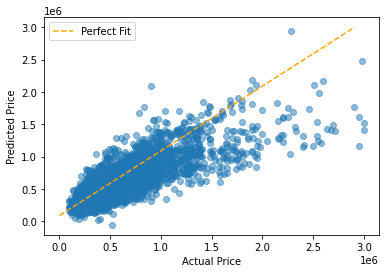

In [344]:
preds = cat_train_reg.predict(X_stripped_down_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

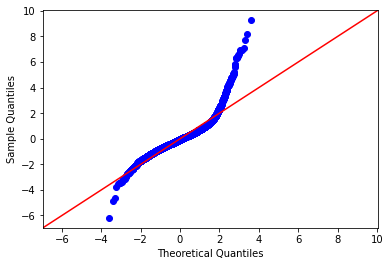

In [345]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [346]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_stripped_down_train.values, i) for i in range(X_stripped_down_train.shape[1])]
vif = [f'!!!{val} > 5, Too High!!!' if val > 5 else val for val in vif]
pd.Series(vif, index=X_stripped_down_train.columns, name="Variance Inflation Factor")

bedrooms                  !!!23.4629138374322 > 5, Too High!!!
bathrooms                !!!25.82934640316396 > 5, Too High!!!
sqft_living             !!!26.729333906713386 > 5, Too High!!!
sqft_lot                                               1.18172
floors                  !!!13.723561887187625 > 5, Too High!!!
waterfront                                             1.01622
yr_built                 !!!76.24572268901393 > 5, Too High!!!
Grade: 11                                              1.38098
Grade: 12                                              1.09904
Grade: 13                                              1.02164
Grade: 3                                               1.00419
Grade: 4                                                1.0628
Grade: 5                                               1.50036
Grade: 6                                               4.64884
Grade: 7                !!!14.048252602272274 > 5, Too High!!!
Grade: 8                 !!!8.181474188011105 > 5, Too 

Only a few columns with multicollinearity so we can drop one or two and see what happens.

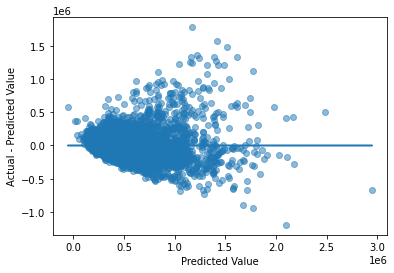

In [347]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_stripped_down_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");


In [348]:
def check_inference_usefulness(model, X_train, X_test, y_test):
    """A function to check the potential usefullness of a model to an inferential perspective.
    Requires scipy.stats as stats and statsmodel as sm. Code taken from Linear Regression cumulative lab."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))

    # Create prediction list and residuals
    preds = model.predict(X_test)
    residuals = (y_test - preds)

    # Plot for linearity assumption
    perfect_line = np.arange(y_test.min(), y_test.max())
    axes[0].plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
    axes[0].scatter(y_test, preds, alpha=0.5)
    axes[0].set_xlabel("Actual Dependent Variable")
    axes[0].set_ylabel("Predicted Dependent Variable")
    axes[0].legend()

    # Plot for normality checking
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

    # Plot to check homoscedasticity
    axes[1].scatter(preds, residuals, alpha=0.5)
    axes[1].plot(preds, [0 for i in range(len(X_test))])
    axes[1].set_xlabel("Predicted Value")
    axes[1].set_ylabel("Actual - Predicted Value");

    # Multicollinearity checking, anything over 5 is considered too high.
    vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif = [f'!!!{val} > 5, Too High!!!' if val > 5 else val for val in vif]
    return pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

    

bedrooms                  !!!23.4629138374322 > 5, Too High!!!
bathrooms                !!!25.82934640316396 > 5, Too High!!!
sqft_living             !!!26.729333906713386 > 5, Too High!!!
sqft_lot                                               1.18172
floors                  !!!13.723561887187625 > 5, Too High!!!
waterfront                                             1.01622
yr_built                 !!!76.24572268901393 > 5, Too High!!!
Grade: 11                                              1.38098
Grade: 12                                              1.09904
Grade: 13                                              1.02164
Grade: 3                                               1.00419
Grade: 4                                                1.0628
Grade: 5                                               1.50036
Grade: 6                                               4.64884
Grade: 7                !!!14.048252602272274 > 5, Too High!!!
Grade: 8                 !!!8.181474188011105 > 5, Too 

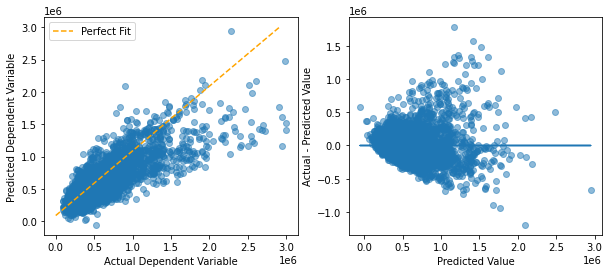

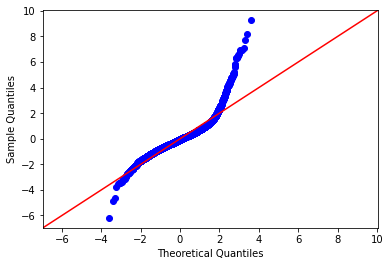

In [349]:
check_inference_usefulness(cat_train_reg, X_stripped_down_train, X_stripped_down_test, y_test)

In [360]:
X_inference_train = X_stripped_down_train.drop(['yr_built', 'Condition: Fair', 'Condition: Poor', 'bathrooms', 'floors', 'bedrooms'], axis=1)
X_inference_test = X_stripped_down_test.drop(['yr_built', 'Condition: Fair', 'Condition: Poor', 'bathrooms', 'floors', 'bedrooms'], axis=1)

In [361]:
inference_reg = LinearRegression()
inference_reg.fit(X_inference_train, y_train)
print(f"R Squared Score: {inference_reg.score(X_inference_train, y_train)}")
print(f"Coefficients: {inference_reg.coef_}")
sm_inference_req = sm.OLS(y_train, sm.add_constant(X_inference_train)).fit()
sm_inference_req.summary()

R Squared Score: 0.5995670861154601
Coefficients: [ 1.28197803e+02 -2.40673184e-01  5.99604689e+05  2.58478073e+05
  5.62693707e+05  9.64071214e+05 -5.41169500e+05 -4.74845503e+05
 -5.10811655e+05 -4.77175211e+05 -4.32676691e+05 -3.52398860e+05
 -1.99726131e+05  5.64800933e+04  1.49038791e+05]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     1504.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:10:23   Log-Likelihood:            -2.0626e+05
No. Observations:               15086   AIC:                         4.126e+05
Df Residuals:                   15070   BIC:                         4.127e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.906e+05   1.29e+04     45.817      0.000    5.65e+05    6.16e+05
sqft_living            128.1978      3.000     42.738      0.000     122.318     134.077
sqft_lot                -0.2407      0.040     -6.016      0.000      -0.319      -0.162
waterfront            5.996e+05   2.23e+04     26.918      0.000    5.56e+05    6.43e+05
Grade: 11             2.585e+05   1.51e+04     17.132      0.000    2.29e+05    2.88e+05
Grade: 12             5.627e+05    3.1e+04     18.145      0.000    5.02e+05    6.23e+05
Grade: 13             9.641e+05   8.65e+04     11.149      0.000    7.95e+05    1.13e+06
Grade: 3             -5.412e+05    2.1e+05     -2.574      0.010   -9.53e+05   -1.29e+05
Grade: 4             -4.748e+05   4.95e+04     -9.590      0.000   -5.72e+05   -3.78e+05
Grade: 5             -5.108e+05   1.91e+04    -26.709      0.000   -5.48e+05   -4.73e+05
Grade: 6             -4.772e+05   1.18e+04    -40.609      0.000      -5e+05   -4.54e+05
Grade: 7             -4.327e+05   9729.819    -44.469      0.000   -4.52e+05   -4.14e+05
Grade: 8             -3.524e+05   9113.962    -38.666      0.000    -3.7e+05   -3.35e+05
Grade: 9             -1.997e+05   9185.884    -21.743      0.000   -2.18e+05   -1.82e+05
Condition: Good       5.648e+04   3996.187     14.133      0.000    4.86e+04    6.43e+04
Condition: Very Good   1.49e+05   6490.911     22.961      0.000    1.36e+05    1.62e+05
==============================================================================
Omnibus:                     5718.358   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43145.935
Skew:                           1.628   Prob(JB):                         0.00
Kurtosis:                      10.618   Cond. No.                     5.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [362]:
inference_reg.score(X_inference_test, y_test)

0.5952022131406738

sqft_living             !!!5.517922203201129 > 5, Too High!!!
sqft_lot                                               1.1666
waterfront                                            1.01352
Grade: 11                                              1.3399
Grade: 12                                             1.09174
Grade: 13                                             1.01777
Grade: 3                                              1.00095
Grade: 4                                              1.00159
Grade: 5                                              1.02271
Grade: 6                                              1.20542
Grade: 7                                              2.42248
Grade: 8                                              2.43445
Grade: 9                                              2.02416
Condition: Good                                       1.45057
Condition: Very Good                                  1.14517
Name: Variance Inflation Factor, dtype: object

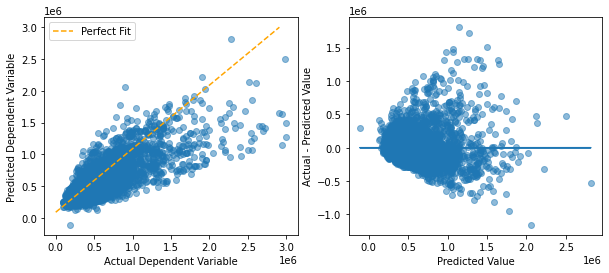

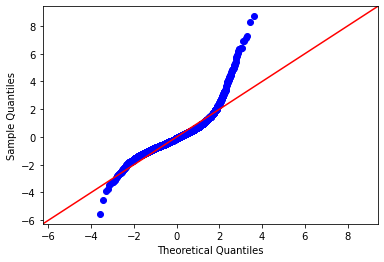

In [363]:
check_inference_usefulness(inference_reg, X_inference_train, X_inference_test, y_test)